## DUOMENŲ ĮKĖLIMAS, APŽIŪRĖJIMAS IR REDAGAVIMAS

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split

In [48]:
from google.colab import files
uploaded = files.upload()

Saving flatland_test.data to flatland_test (1).data
Saving flatland_train.data to flatland_train (1).data


In [107]:
import pickle, gzip
path_to_flatland_train_data = 'flatland_train.data'
X_train, y_train = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
path_to_flatland_test_data = 'flatland_test.data'
X_test, y_test = pickle.load(gzip.open(path_to_flatland_test_data, 'rb'))

In [108]:
print(X_train.shape, y_train.shape)
# Turime 10 000 paveikslėlių, 50x50px, ir 10000 labels

(10000, 50, 50) (10000,)


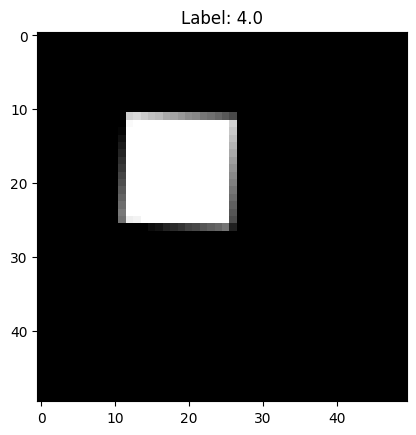

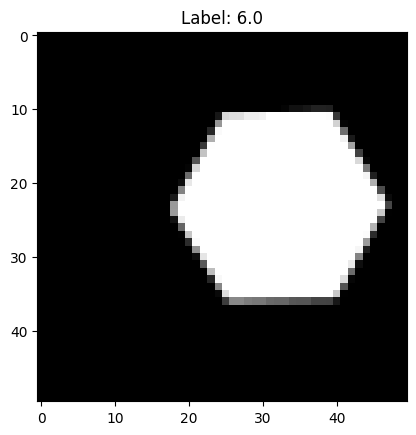

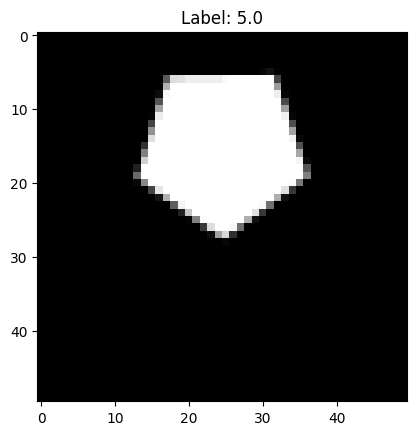

In [109]:
# Peržiūrime kelis paveiksėlius
import matplotlib.pyplot as plt
for i in range(3):
    plt.figure()
    plt.imshow(X_train[i], cmap = 'gray')
    plt.title(f"Label: {y_train[i]}")
    plt.show()

In [110]:
# Sumaišome duomenis, kad modelis neišmokų nenorimų struktūrų ar sekų
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [111]:
# Konvertuojame:
X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)

In [112]:
# Normalizuojame duomenis
X_train = X_train / 255.0
X_test = X_test / 255.0

In [114]:
# Pritaikysime Sobel filtrus figūrų kraštinių išryškinimui
from scipy.ndimage import sobel
def apply_sobel(pav):
    pav_sobel = np.zeros_like(pav)

    for i in range(pav.shape[0]):
        img = pav[i].numpy()

        sobel_x = sobel(img, axis=1)
        sobel_y = sobel(img, axis=0)

        sobel_img = np.hypot(sobel_x, sobel_y)

        pav_sobel[i] = sobel_img

    return tf.convert_to_tensor(pav_sobel, dtype=tf.float32)

X_train_edges = apply_sobel(X_train)
X_test_edges = apply_sobel(X_test)


print(X_train_edges.shape)
print(X_test_edges.shape)

(10000, 50, 50)
(10000, 50, 50)


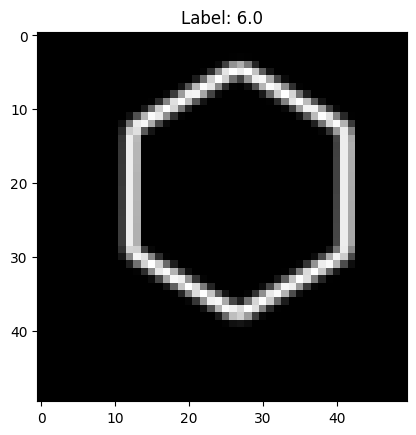

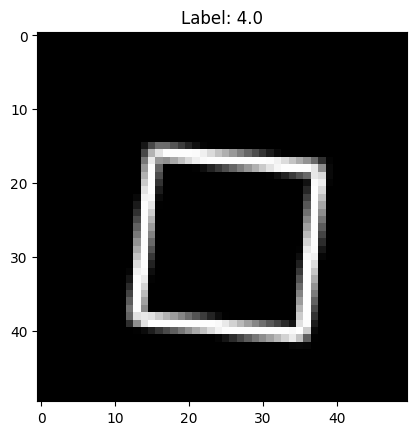

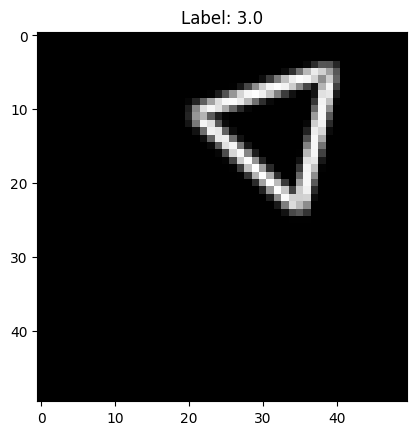

In [115]:
for i in range(3):
    plt.figure()
    plt.imshow(X_train_edges[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.show()

In [116]:
X_train_edges = np.expand_dims(X_train_edges, axis=-1)

In [117]:
print(X_train_edges.shape)
# Turime, kad kintamasis X_train_edges turi keturias dimensijas (pav. kiekis, aukštis, plotis, 'channels'), kas bus reikalinga CNN modeliui

(10000, 50, 50, 1)


In [ ]:
# Kad modelio treniravimui galėtume generuoti daugiau paveikslėlių, transformuojame turimus
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

#train_datagen.fit(X_train_edges)
#train_generator = train_datagen.flow(X_train_edges, y_train, batch_size=32)

train_datagen.fit(X_train_edges)
x = X_train_edges[0]
x = x.reshape((1,) + x.shape)

In [120]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape, y_batch.shape)
    break

(32, 52, 52, 1) (32,)


## CNN MODELIS

In [121]:
# Nurodome modelio struktūrą (sequential)
model = keras.Sequential([

    # Pirmas convolutional layer
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(52, 52, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Antras convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Trečias convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Ketvirtas convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Konvertuojame 2D "feature maps" į vektorių
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Kad nebūtų overfitting

    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
model.compile(
    optimizer='adam',  # optimizatorius treniravimui
    loss='sparse_categorical_crossentropy',  # error suskaičiavimas
    metrics=['accuracy']  # modelio tikslumo įvertinimas
)

In [123]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 50, 50, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 23, 23, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 23, 23, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 115,914 (452.79 KB)

 Trainable params: 115,434 (450.91 KB)

 Non-trainable params: 480 (1.88 KB)

In [124]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [126]:
# ModelCheckpoint geriausio modelio išsaugojimui
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'best_model_{epoch:02d}.weights.h5',
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = True,
    verbose = 1
    )

## TRENIRUOJAME CNN MODELĮ

In [127]:
x_training, x_testing, y_training, y_testing = train_test_split(X_train_edges, y_train, test_size=0.2, random_state=42)

In [128]:
train_generator = train_datagen.flow(
    x_training,
    y_training,
    batch_size=32,
    shuffle=True
)

In [129]:
model.fit(
    train_generator,
    epochs=40,
    validation_data=(x_testing, y_testing),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2341 - loss: 2.6105
Epoch 1: val_loss improved from inf to 2.28634, saving model to best_model_01.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.2342 - loss: 2.6082 - val_accuracy: 0.2830 - val_loss: 2.2863
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3377 - loss: 1.5436
Epoch 2: val_loss improved from 2.28634 to 1.21824, saving model to best_model_02.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.3378 - loss: 1.5434 - val_accuracy: 0.4690 - val_loss: 1.2182
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4154 - loss: 1.3511
Epoch 3: val_loss improved from 1.21824 to 1.06778, saving model to best_model_03.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.4155 - loss: 1.3511 - val_accuracy: 0.5245 - val_loss: 1.0678
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4636 - loss: 1.2563
Epoch 4: val_loss improved

In [130]:
test_loss, test_acc = model.evaluate(x_testing,  y_testing, verbose=2)
print('\nTikslumas:', test_acc)

63/63 - 1s - 21ms/step - accuracy: 0.9840 - loss: 0.1514

Tikslumas: 0.984000027179718


In [131]:
predictions = model.predict(X_test_edges)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


In [132]:
predictions_labels = [np.argmax(pred) for pred in predictions]
predictions_string = ''.join([str(round(p)) for p in predictions_labels])

In [133]:
print(predictions_string)

6545533343400053340545465645540463060355660333004353364356654054553303665503043350530654500355354463530403305345345040035360550004655530445455543654345046545635635636546303536556366660360305655463536336353336335465363306053566453350450054500063445060345643400453633465445546354503340300344553655053533306444055363443403030606300064555506334560544330054354500443044350645463346050306554305053645044355533336536330650544345554354535053644433553304055544504505345553050664300303444544504030306344006554333400506036544330334035643434343650403330363543435603566453440550643403430450565505303434536654350435035004453056464566035403330463450364406563043554443345350563053556650664533336350334356344353343060333043443433504546433334035630064450544503643600503355633556300553303033035463444450546453433660505604345455536403330035505464056564430553033365330544530633643635653364030035430440356634344063556033036433354560635035440504640055344340360630645656404363635646435404000565355305364503035300453655355504

In [134]:
model.save('FLATLAND_modelis.h5')
files.download('FLATLAND_modelis.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>